In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-white')

import json
import urllib
import requests
import os
import imageio

# For scraping an image using a remote browser
from selenium import webdriver

from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.offsetbox import OffsetImage
from bs4 import BeautifulSoup

# Models
from sklearn.cluster import MeanShift, KMeans

In [5]:
class Player:
    def __init__(self, playerID, year, seasonType, shot_result, save=False, model_and_params=None):
        '''
        Parameters:
        
        playerID: Used for identifying the player
        seasonType: 0 -> Regular Season, 1 -> Playoffs
        shot_result: 0 -> Missed, 1 -> Made, 2 -> FGAs
        save: Saves the image into a directory
        
        '''
        self.playerID = str(playerID)
        self.year = str(year)
        self.shot_result = shot_result
    
        if seasonType==0:
            self.seasonType = 'Regular+Season'
        if seasonType==1:
            self.seasonType = 'Playoffs'    
            
        self.model = model_and_params
        self.save = save
        
        if model_and_params!=None:
            # Model = 1, KMeans
            if model_and_params[0]==1:
                self.model = KMeans(n_clusters=model_and_params[1], random_state=0)
            # Model = 2, Meanshift
            if model_and_params[0]==2:
                self.model = MeanShift(bandwidth=model_and_params[1])
            
            
        
    ### METHODS
    def shot_locations_data(self):
    # Scrapes the data
        year = self.year
        season_year = year[:5] + year[-2:]

        # URL for the stats
        start_url = 'https://stats.nba.com/stats/shotchartdetail?AheadBehind=&CFID=33&CFPARAMS='
        mid_url1 = '&ClutchTime=&Conference=&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&Division=&EndPeriod=10&EndRange=28800&GROUP_ID=&GameEventID=&GameID=&GameSegment=&GroupID=&GroupMode=&GroupQuantity=5&LastNGames=0&LeagueID=00&Location=&Month=0&OnOff=&OpponentTeamID=0&Outcome=&PORound=0&Period=0&PlayerID='
        mid_url2 = '&PlayerID1=&PlayerID2=&PlayerID3=&PlayerID4=&PlayerID5=&PlayerPosition=&PointDiff=&Position=&RangeType=0&RookieYear=&Season='
        mid_url3 = '&SeasonSegment=&SeasonType='
        end_url = '&ShotClockRange=&StartPeriod=1&StartRange=0&StarterBench=&TeamID=0&VsConference=&VsDivision=&VsPlayerID1=&VsPlayerID2=&VsPlayerID3=&VsPlayerID4=&VsPlayerID5=&VsTeamID='

        shot_chart_url = start_url + season_year + mid_url1 + self.playerID +  mid_url2 + season_year + mid_url3 + self.seasonType + end_url

        # Fake agent
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

        ## Gets the player name
        url = 'https://stats.nba.com/player/' + str(self.playerID) + '/'
        html = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(html, "html.parser")

        # Retrieve all of contents from the p tags
        tags = soup('p')
        contents = [tag.contents[0] for tag in tags]
        contents = contents[:2]

        # Returns the full name
        self.fullname = contents[0] + ' ' + contents[1]      
        
    # Pre-processing of the data
        player_stats = requests.get(shot_chart_url, headers=headers)
        headers_data = player_stats.json()['resultSets'][0]['headers']
        shots = player_stats.json()['resultSets'][0]['rowSet']
        
        data = pd.DataFrame(shots, columns=headers_data)
        
        if len(data)==0:
            return 'Invalid'
        
        # Getting the team_name
        self.team_name = np.unique(data['TEAM_NAME'])[0]
        
        # Getting the number of games played
        self.games_played = len(np.unique(data['GAME_ID']))
            
        
        # Changing event_type values
        data['EVENT_TYPE'].replace({'Missed Shot':0, 'Made Shot':1}, inplace=True)

        # Changing shot_type values
        data['SHOT_TYPE'].replace({'2PT Field Goal':2, '3PT Field Goal':3}, inplace=True)
        two_pt_FGAs = data[data['SHOT_TYPE']==2]
        three_pt_FGAs = data[data['SHOT_TYPE']==3]

        # FG pcts
        zeros = '00000'
        try:
            two_pt_fgpct = len(two_pt_FGAs[two_pt_FGAs['EVENT_TYPE']==1]) / len(two_pt_FGAs)
            two_pt_fgpct = str(two_pt_fgpct * 100) + zeros
            self.two_pt_fgpct = two_pt_fgpct[:5]
        except:
            self.two_pt_fgpct = str(0)
        
        try:
            three_pt_fgpct = len(three_pt_FGAs[three_pt_FGAs['EVENT_TYPE']==1])/len(three_pt_FGAs)
            three_pt_fgpct = str(three_pt_fgpct * 100) + zeros
            self.three_pt_fgpct = three_pt_fgpct[:5]
        
        except:
            self.three_pt_fgpct = str(0)
            
        # Getting total FG%
        try:
            fg_pct = (len(two_pt_FGAs[two_pt_FGAs['EVENT_TYPE']==1]) + len(three_pt_FGAs[three_pt_FGAs['EVENT_TYPE']==1]))/(len(two_pt_FGAs) + len(three_pt_FGAs))
            fg_pct = str(fg_pct * 100) + zeros
            self.fg_pct = fg_pct[:5]
        
        except:
            self.fg_pct = str(0)
    
        # Field Goals made
        self.two_pm = len(two_pt_FGAs[two_pt_FGAs['EVENT_TYPE']==1])
        self.three_pm = len(three_pt_FGAs[three_pt_FGAs['EVENT_TYPE']==1])
        
        # Dropping unnecessary columns
        cols_drop = ['GAME_EVENT_ID', 'GRID_TYPE', 'GAME_ID', 'PLAYER_ID', 
                     'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME', 'PERIOD', 
                     'MINUTES_REMAINING', 'SECONDS_REMAINING','SHOT_ZONE_BASIC', 
                     'SHOT_ZONE_AREA', 'SHOT_DISTANCE', 'SHOT_ZONE_RANGE',
                     'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM']
        data = data.drop(columns=cols_drop)
        
        
        # Location of each field goal attempt
        # Missed
        if self.shot_result==0:
            return data[data['EVENT_TYPE'] == 0][['LOC_X', 'LOC_Y']]
        
        # Made
        if self.shot_result==1:
            return data[data['EVENT_TYPE'] == 1][['LOC_X', 'LOC_Y']]
        
        # All
        if self.shot_result==2:
            return data[['LOC_X', 'LOC_Y']]
            
            
            
    def plot_shot_chart(self, X, img_size=(8,8)):
        def draw_court(ax=None, color='white', lw=1, outer_lines=True):
        # If an axes object isn't provided to plot onto, just get current one
            if ax is None:
                ax = plt.gca()

        # Create the basketball hoop
            hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

            # Create backboard
            backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

        # The paint
            # Create the outer box 0f the paint, width=16ft, height=19ft
            outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                                  fill=False)
            # Create the inner box of the paint, widt=12ft, height=19ft
            inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                                  fill=False)

        # Free Throw
            # Create free throw top arc
            top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                                 linewidth=lw, color=color, fill=False)
            # Create free throw bottom arc
            bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                                    linewidth=lw, color=color, linestyle='dashed')

        # Restricted Zone, it is an arc with 4ft radius from center of the hoop
            restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                             color=color)

        # Three point line
            # Create the side 3pt lines, they are 14ft long before they begin to arc
            corner_three_a = Rectangle((-220, -47.5), 0, 136.8, linewidth=lw,
                                       color=color)
            corner_three_b = Rectangle((220, -47.5), 0, 136.8, linewidth=lw, color=color)

            # 3pt arc
            three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                            color=color)

            # Center Court
            center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                                   linewidth=lw, color=color)
            center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                                   linewidth=lw, color=color)


            # List of the court elements to be plotted onto the axes
            court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                              bottom_free_throw, restricted, corner_three_a,
                              corner_three_b, three_arc, center_outer_arc,
                              center_inner_arc]

            if outer_lines:
                # Draw the half court line, baseline and side out bound lines
                outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                        color=color, fill=False)
                court_elements.append(outer_lines)

            # Add the court elements onto the axes
            for element in court_elements:
                ax.add_patch(element)

        # Adding the player_image
            player_logo_path = 'Player Headshots and Logos\\'

            # If the directory for the players and logos does not exists, we create a directory
            if not os.path.exists(player_logo_path):
                os.makedirs(player_logo_path)

            # If the player's picture does exists in the directory, we simply add the picture 
            # without scaping it 
            player_pic_path = player_logo_path + self.fullname + '.png'
            if not os.path.exists(player_pic_path):
                #Player image
                # There are some players that do not have head-shots from the nba website
                # so we scrape the player image from another website
                try:
                    gecko_path = 'C:/Users/tonba/Desktop/Code Workspace/Python/Basketball/Shot Charts'
                    browser = webdriver.Firefox(gecko_path) 
                    browser.get('https://stats.nba.com/player/'+ str(self.playerID) +'/')
                    data_html = BeautifulSoup(browser.page_source, "html.parser")

                    # Getting the image of the player
                    player_image_url = data_html.find('img', attrs={'class':'player-img'})['src']
                    browser.close()
                    browser.quit()

                    pic = urllib.request.urlretrieve(player_image_url, 
                                                 '{}\\{}.png'.format(player_logo_path, self.fullname))
                    player_pic = plt.imread(pic[0])

                    # 260x190, Error = 230x185
                except: # catch *all* exceptions
                    pic = urllib.request.urlretrieve("https://stats.nba.com/media/players/230x185/" + \
                                                     str(self.playerID)+".png", player_pic_path)

                    with Image(filename=player_pic_path) as image_:
                        # Resizing the alternative image to be like the same size of the original
                        image_.resize(int(1.165*230), 185)
                        image_.save(filename=player_pic_path)

                    player_pic = plt.imread(pic[0])

                from matplotlib import offsetbox as osb
                player_img = osb.OffsetImage(player_pic, zoom=0.4)
                player_img = osb.AnnotationBbox(player_img, (59,360),xycoords='data',
                                                pad=0.0, box_alignment=(1,0), frameon=False)
                ax.add_artist(player_img)

            # If the image exists inside the directory, we simply plot it
            if os.path.exists(player_pic_path):
                player_pic = plt.imread(player_pic_path)
                from matplotlib import offsetbox as osb
                player_img = osb.OffsetImage(player_pic, zoom=0.4)
                player_img = osb.AnnotationBbox(player_img, (59,360),xycoords='data',pad=0.0, 
                                                box_alignment=(1,0), frameon=False)
                ax.add_artist(player_img)


            # Getting Team Logos from sportslogohistory.com
            team_name_ = self.team_name
            team_logo_png_filename = player_logo_path + team_name_ +'.png'

            if not os.path.exists(team_logo_png_filename):
                team_lowercase_ = team_name_.lower()
                team_split = team_lowercase_.split()
                team_formatted = ['-'] * (len(team_split) * 2 - 1)
                team_formatted[0::2] = team_split
                str_team_for_url = ''.join(team_formatted)

                url = 'https://sportslogohistory.com/' + str_team_for_url + '-alternate-logo'
                html = urllib.request.urlopen(url).read()
                soup = BeautifulSoup(html, "html.parser")
                logo_image_url = soup.find('img', attrs={'class':'so-widget-image'})['src']


                team_logo_retrieved = urllib.request.urlretrieve(logo_image_url, team_logo_png_filename)
                team_logo_array = plt.imread(team_logo_png_filename)

                logo_img = osb.OffsetImage(team_logo_array, zoom=0.35)
                logo_img = osb.AnnotationBbox(logo_img, (-110,350),xycoords='data',
                                              pad=0.0, box_alignment=(1,0), frameon=False)
                ax.add_artist(logo_img)


            if os.path.exists(team_logo_png_filename):
                team_logo_array = plt.imread(team_logo_png_filename)
                logo_img = osb.OffsetImage(team_logo_array, zoom=0.35)
                logo_img = osb.AnnotationBbox(logo_img, (-110,350),xycoords='data',
                                              pad=0.0, box_alignment=(1,0), frameon=False)
                ax.add_artist(logo_img)


            # Top k hotspots using KMeans
            if self.model!=None:
                fitted_model = self.model.fit(X)
                clusters_centers = fitted_model.cluster_centers_
                ax.scatter(clusters_centers[:,0], clusters_centers[:,1], s=120, facecolors='none',
                           edgecolors='yellow', lw=3)
            
            # Plot stuff
            plt.subplots_adjust(top=0.93)
            ax.set_xlim(-240,240)
            ax.set_ylim(360, -47.5)
            ax.xaxis.label.set_visible(False)
            ax.yaxis.label.set_visible(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            
            # For the title
            if self.seasonType=='Regular+Season':
                self.seasonType = 'Regular Season'  
            
            if self.shot_result == 0:
                title_shot_result = 'Missed Shots'
            if self.shot_result == 1:
                title_shot_result = 'Made Shots'
            if self.shot_result == 2:
                title_shot_result = 'FGAs'

            # Add a title and removing x and y labels
            ax.set_title('{}\n{} {}'.format(self.fullname, title_shot_result, 
                                            self.seasonType), y=1.2, fontsize=12)
            
            GP = str(self.games_played)
            fg_pct = self.fg_pct
            two_fg_pct = str(self.two_pt_fgpct)
            two_pm = str(self.two_pm)
            three_pt_fgpct = str(self.three_pt_fgpct)
            three_pm = str(self.three_pm) 
            

            n = 5 - len(two_fg_pct)
            m = 3 - len(two_pm) 
            o = 5 - len(three_pt_fgpct)
            p = 3 - len(three_pm) 

            #Adding brief stats
            stats_txt = 'Year: {}\nGM:   {}\nFG%: {}\n2P%: {}% {}    2PM: {}{}\n3P%: {}% {}    3PM: {}{}'.format(r"$\bf{" + str(self.year) + "}$",
                                            r"$\bf{" + GP + "}$",
                                            r"$\bf{" + fg_pct + "}$",
                                            r"$\bf{" + two_fg_pct + "}$",
                                            n*' ',
                                            r"$\bf{" + two_pm + "}$",
                                            m*' ',
                                            r"$\bf{" + three_pt_fgpct + "}$", 
                                            o*' ',
                                            r"$\bf{" + three_pm + "}$",
                                            p*' ')
            
    
            props_stats = dict(boxstyle='round', facecolor='peachpuff', edgecolor='black')
            ax.text(110, 290, stats_txt, fontsize=8,
            verticalalignment='top', bbox=props_stats)


            # References
            ax.text(167, 357,'Data Source: stats.nba.com\n'
                    'Player Images from Getty Images\n'
                    'Author: Val Anthony Balagon', color='white',
                    fontsize=4)

            #ax.axvline(0)

            # Saves the figure
            if self.save==True:
                # Makes a folder if the directory doesn't exist
                path = self.fullname
                plt.savefig(path + '/{}_{}_{}.png'.format(self.fullname, self.seasonType, 
                                                           self.year), facecolor='w', dpi=300)
            return ax
        
        # Plots the KDE plot
        cmap = plt.cm.RdGy

        joint_shot_chart = sns.jointplot(X['LOC_X'], X['LOC_Y'], 
                                 shade=True, stat_func=None, kind='kde', space=0, 
                                 color=cmap(0.25), joint_kws={"cut": 10}, cmap=cmap, 
                                 n_levels=100)
        joint_shot_chart.fig.set_size_inches(img_size[0],img_size[1])    
        draw_court(ax=joint_shot_chart.ax_joint, color='white', lw=1, outer_lines=True)

# Testing

<IPython.core.display.Javascript object>


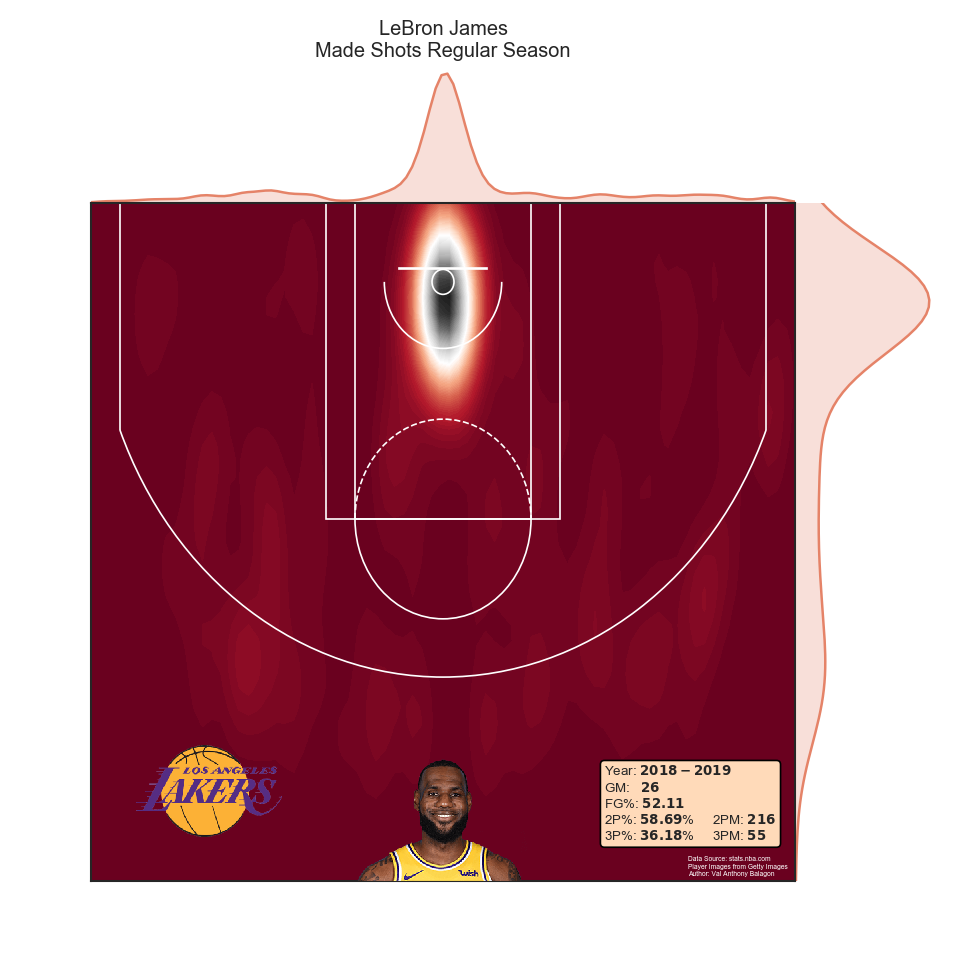

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [6]:
player = Player(2544, '2018-2019', seasonType=0, shot_result=1, save=False, model_and_params=None)
X = player.shot_locations_data()
player.plot_shot_chart(X)

# Makes a series of images into a gif

In [7]:
def year_ranges(start, end):    
    years = [str(year) for year in range(start, end+1)]
    year_ranges = []
    for i in range(0, len(years)):
        if i==len(years)-1:
            break
        else: 
            year_ranges.append(years[i] + '-' + years[i+1])
            
    return year_ranges

In [8]:
def make_gif(playerID, start, end, seasonType, shot_result, 
             model_and_params, save=True, img_size=(8,8)):    
    
    for index, year in enumerate(year_ranges(start, end)):
        player = Player(playerID, year, seasonType, shot_result, save=save, 
                        model_and_params=model_and_params)
        X = player.shot_locations_data()
        if index==0:
            path = player.fullname
            # If the directory does not exists, we create a directory
            if not os.path.exists(path):
                os.makedirs(path)

            # Deletes the contents of the folder if it exists
            if os.path.exists(path):
                # Gets all of the filenames
                filenames = []
                files_present = []
                for (dirpath, dirnames, filenames) in os.walk(path):
                    files_present.extend(filenames)
                    break
            # Removes all of the files 
            for file in filenames:
                os.remove(os.path.join(path, file))
        # Draws the court       
        player.plot_shot_chart(X)
               
        
    # Makes a gif
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        files.extend(filenames)
        break
        
    gif_path = path + "\\" + player.fullname + '_' + str(start) +'-'+ str(end)
    with imageio.get_writer(gif_path+ '.gif', mode='I', fps=2) as writer:
        for filename in files:
            image = imageio.imread(path + "\\" + filename)
            writer.append_data(image)

    writer.close()

<IPython.core.display.Javascript object>


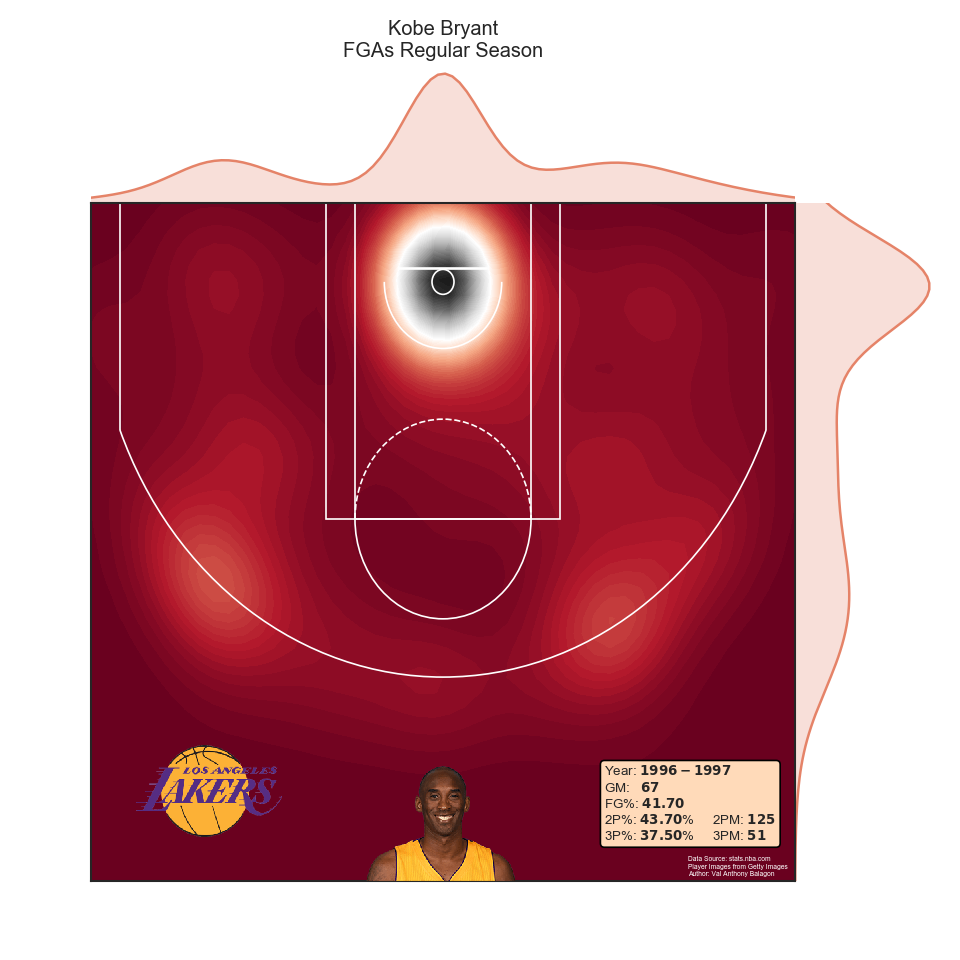

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


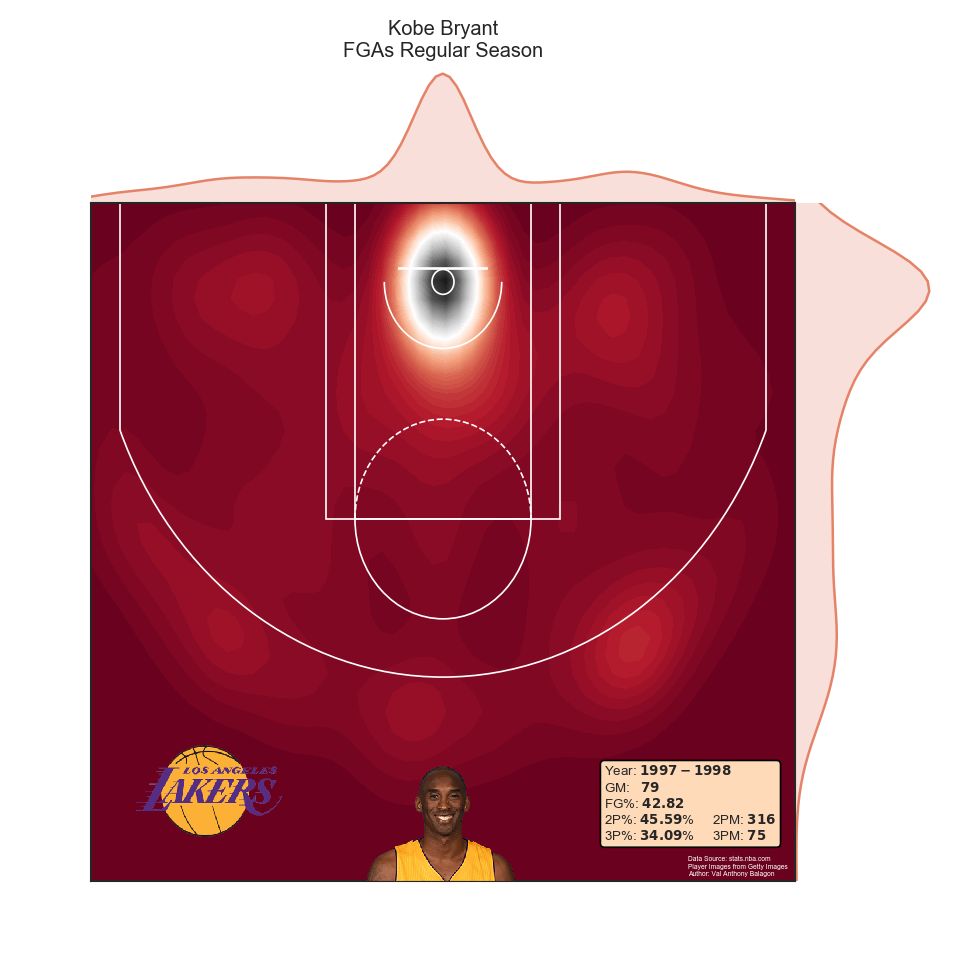

<IPython.core.display.Javascript object>


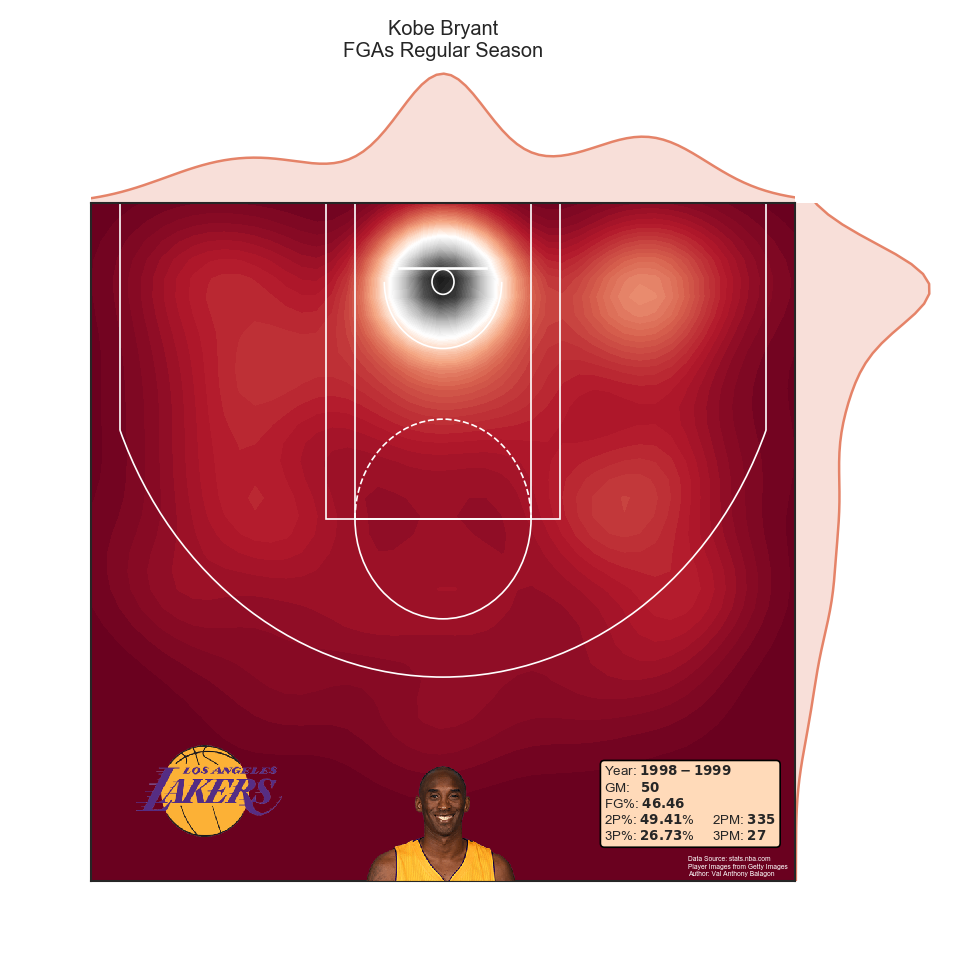

<IPython.core.display.Javascript object>


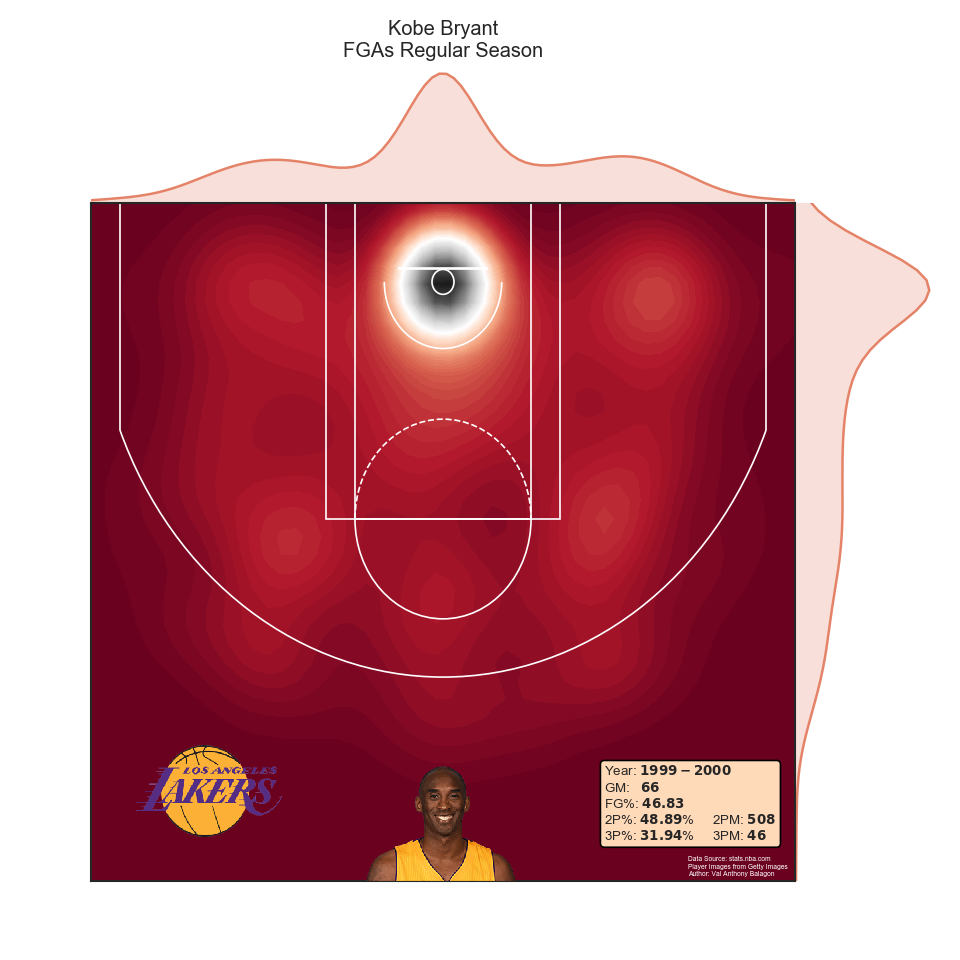

<IPython.core.display.Javascript object>


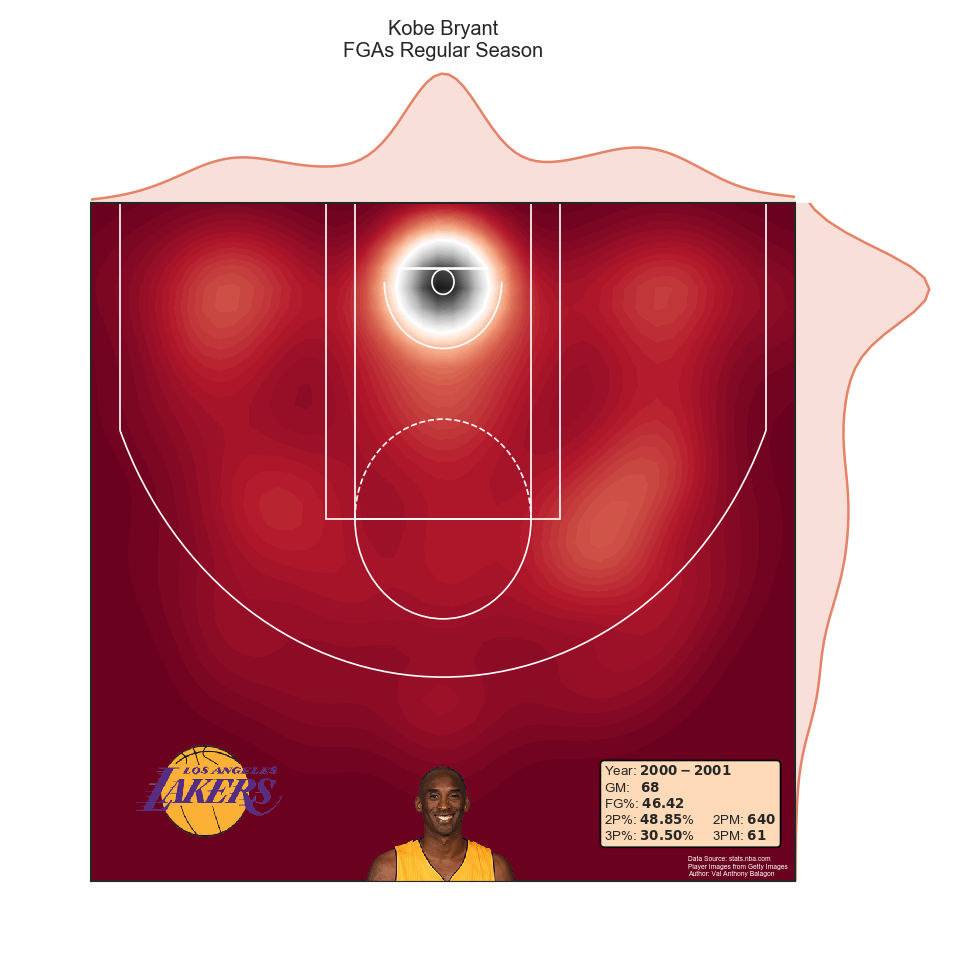

<IPython.core.display.Javascript object>


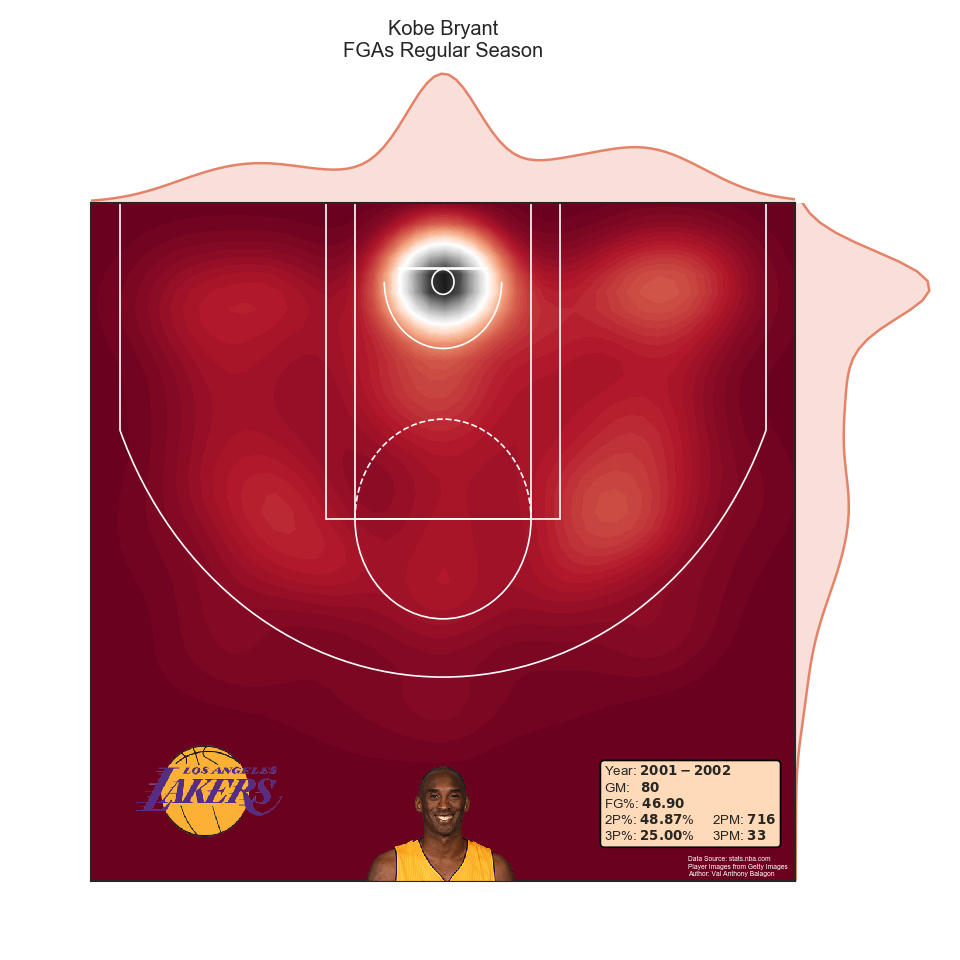

<IPython.core.display.Javascript object>


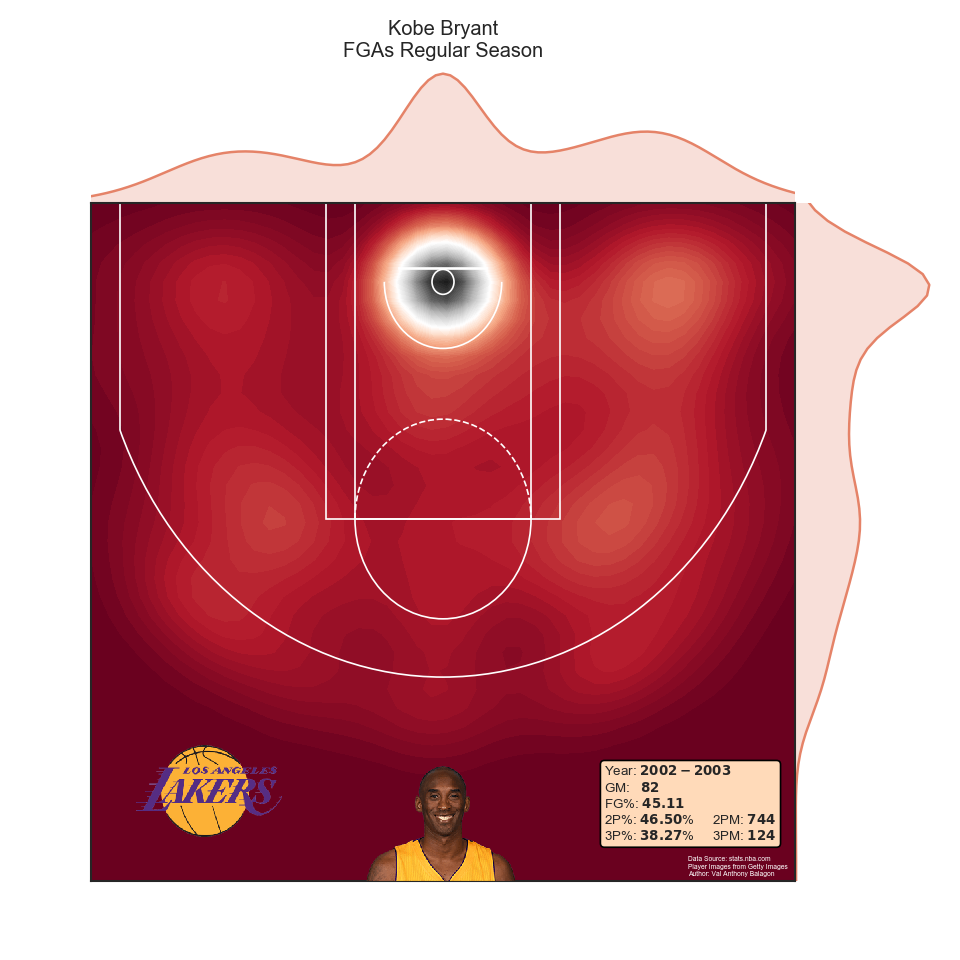

<IPython.core.display.Javascript object>


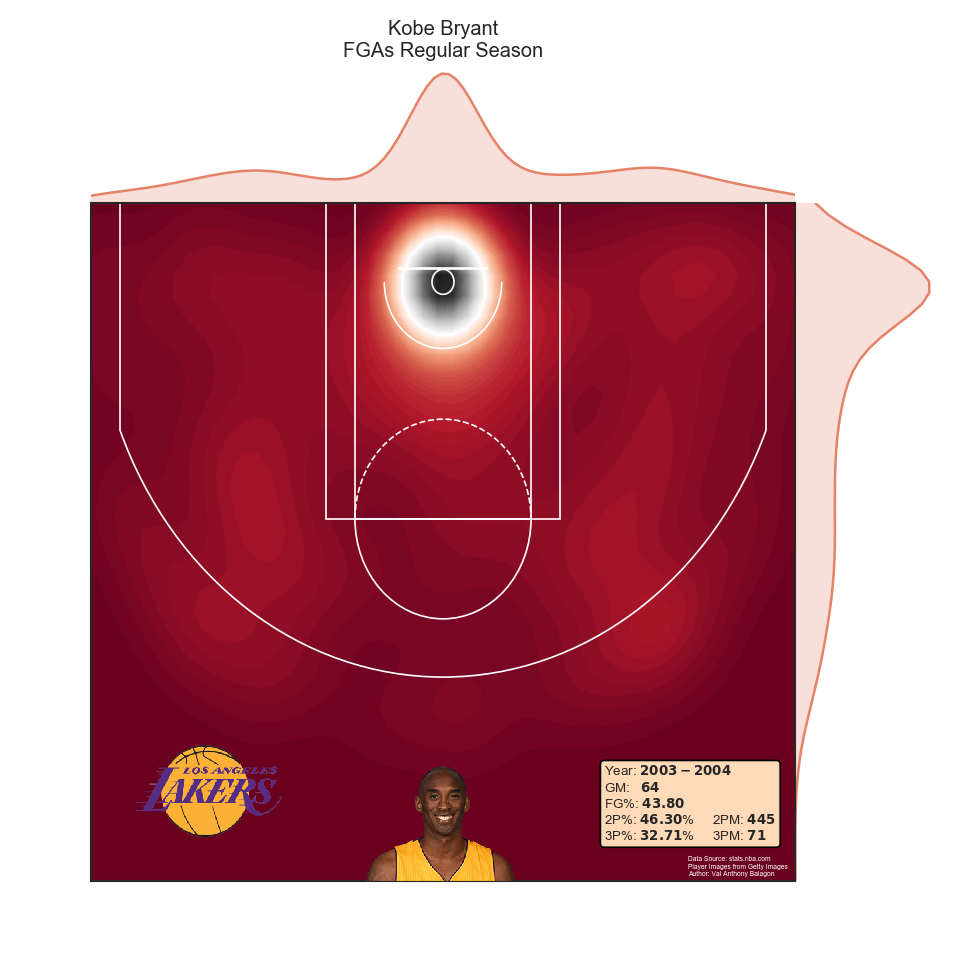

<IPython.core.display.Javascript object>


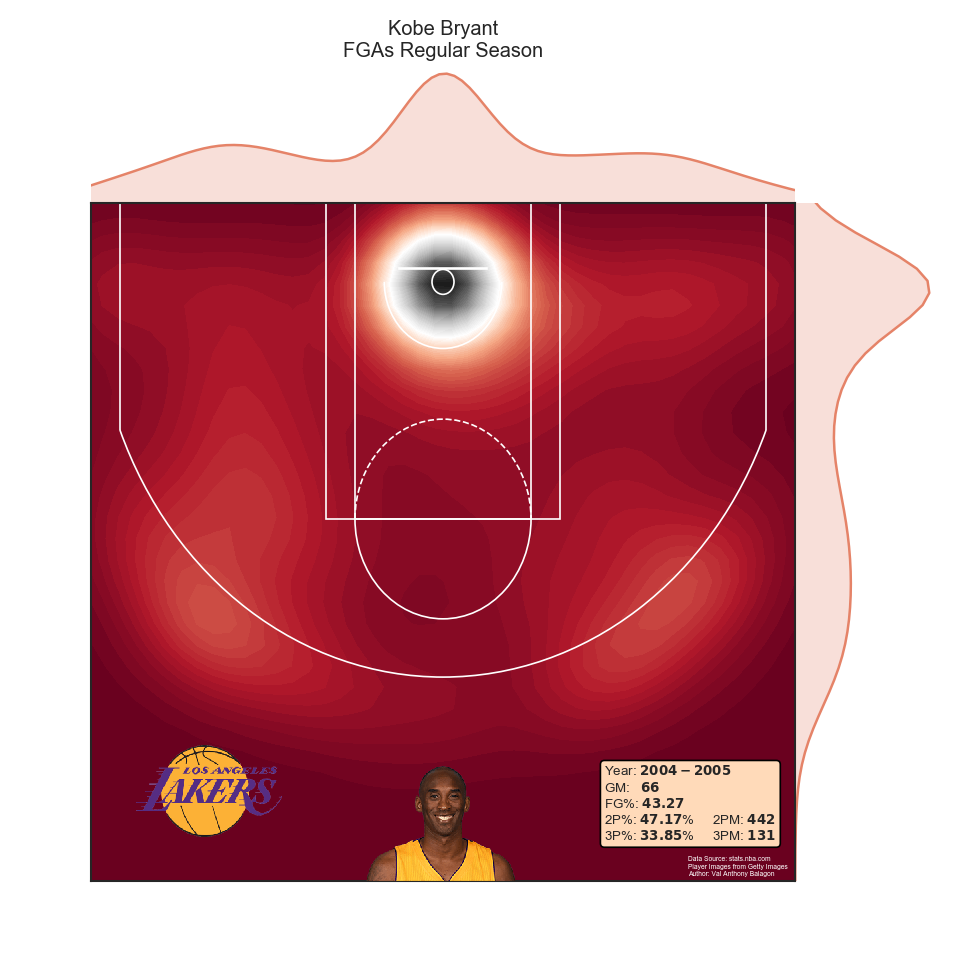

<IPython.core.display.Javascript object>


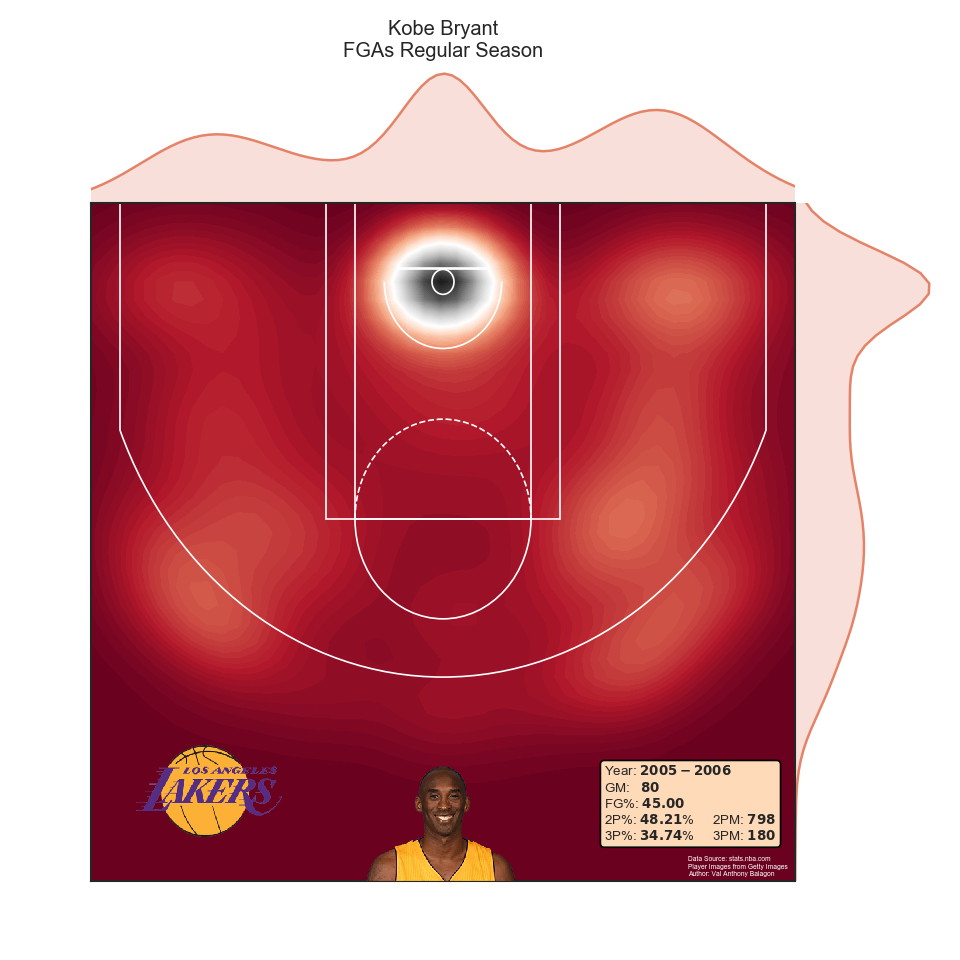

<IPython.core.display.Javascript object>


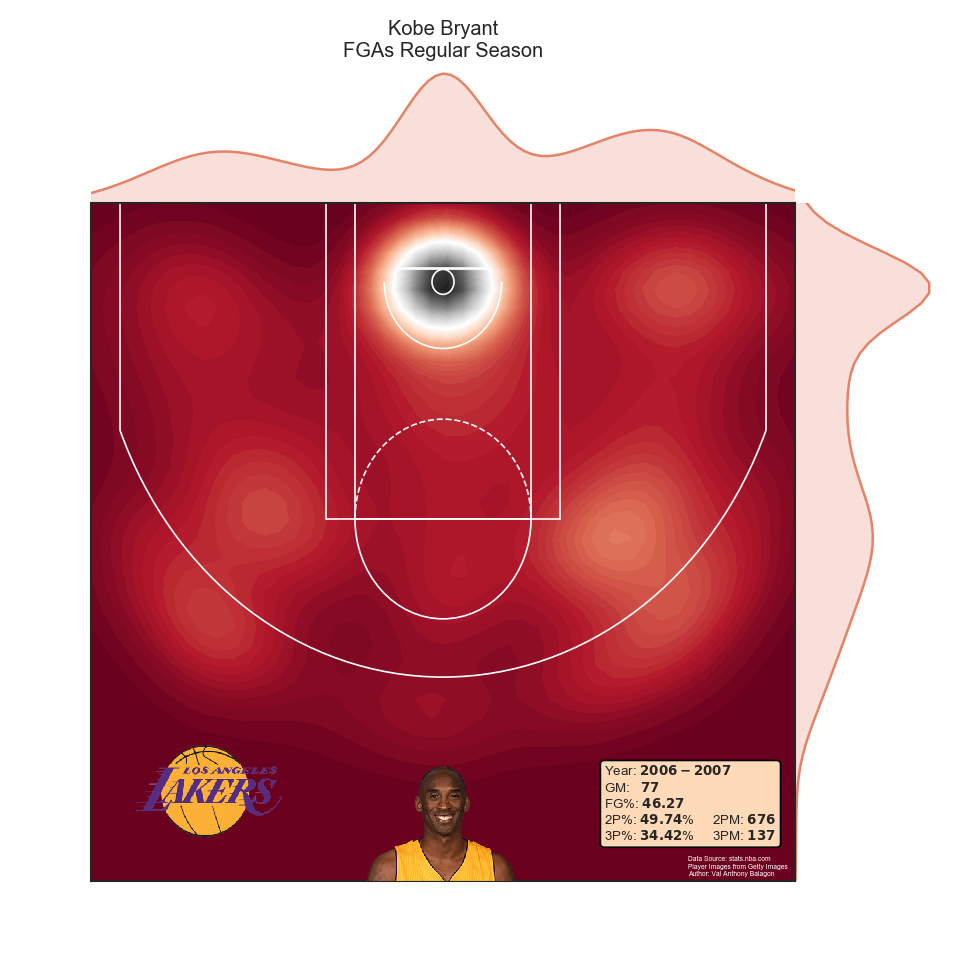

<IPython.core.display.Javascript object>


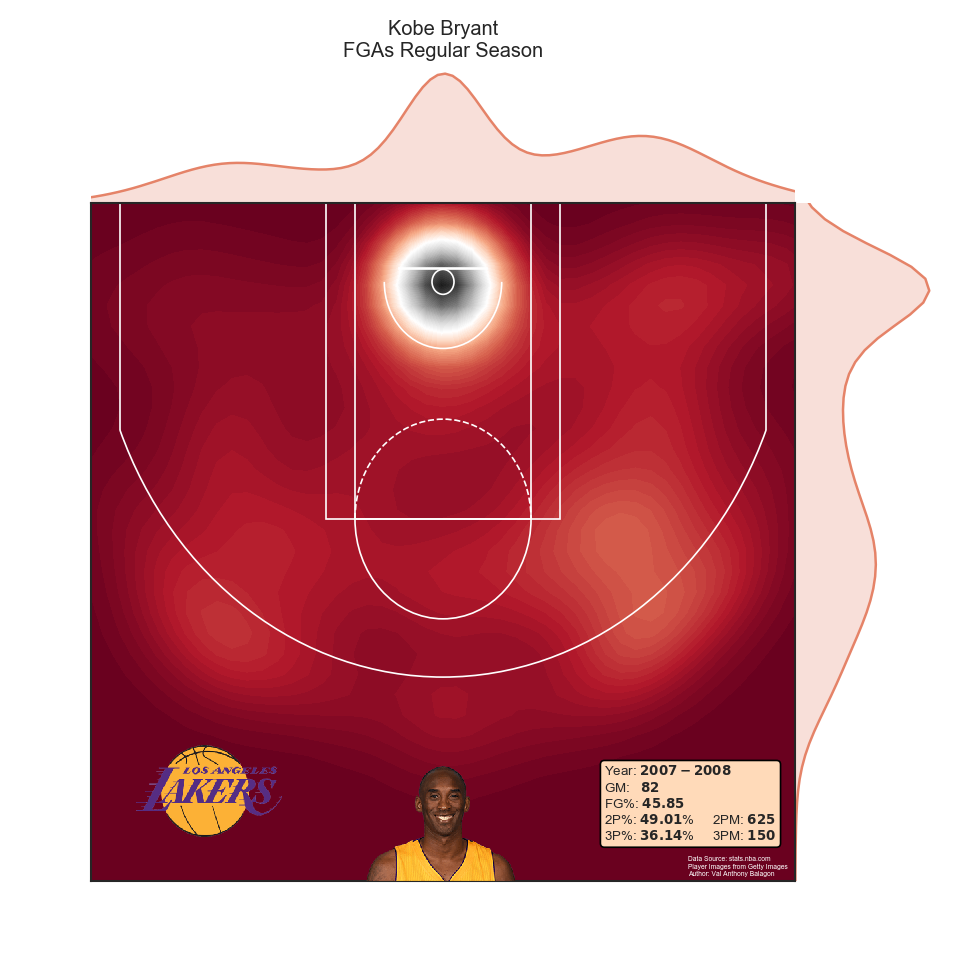

<IPython.core.display.Javascript object>


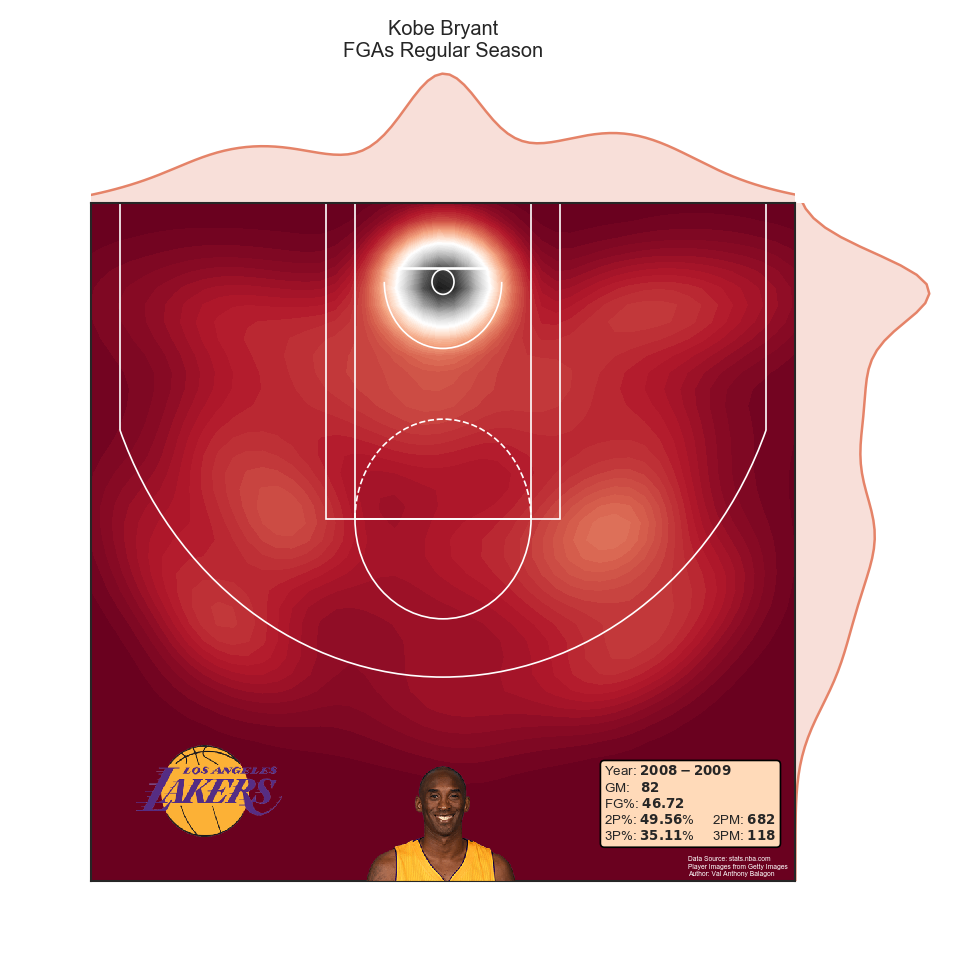

<IPython.core.display.Javascript object>


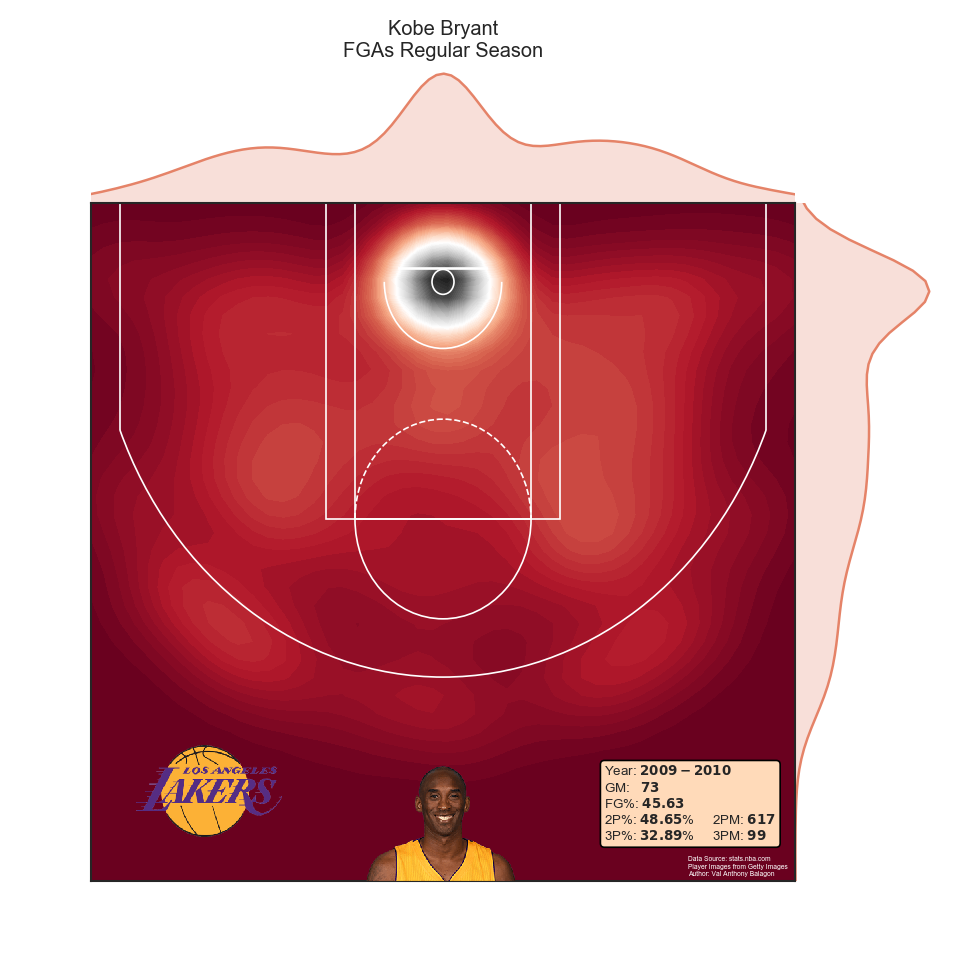

<IPython.core.display.Javascript object>


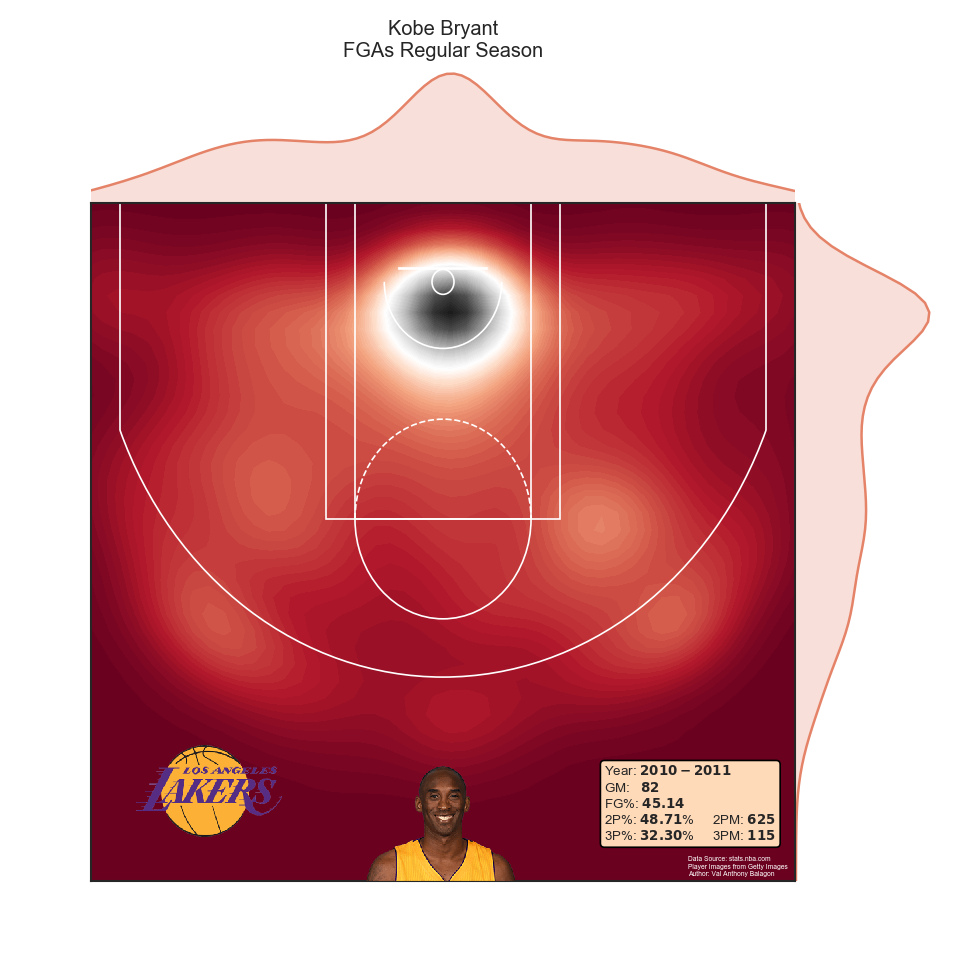

<IPython.core.display.Javascript object>


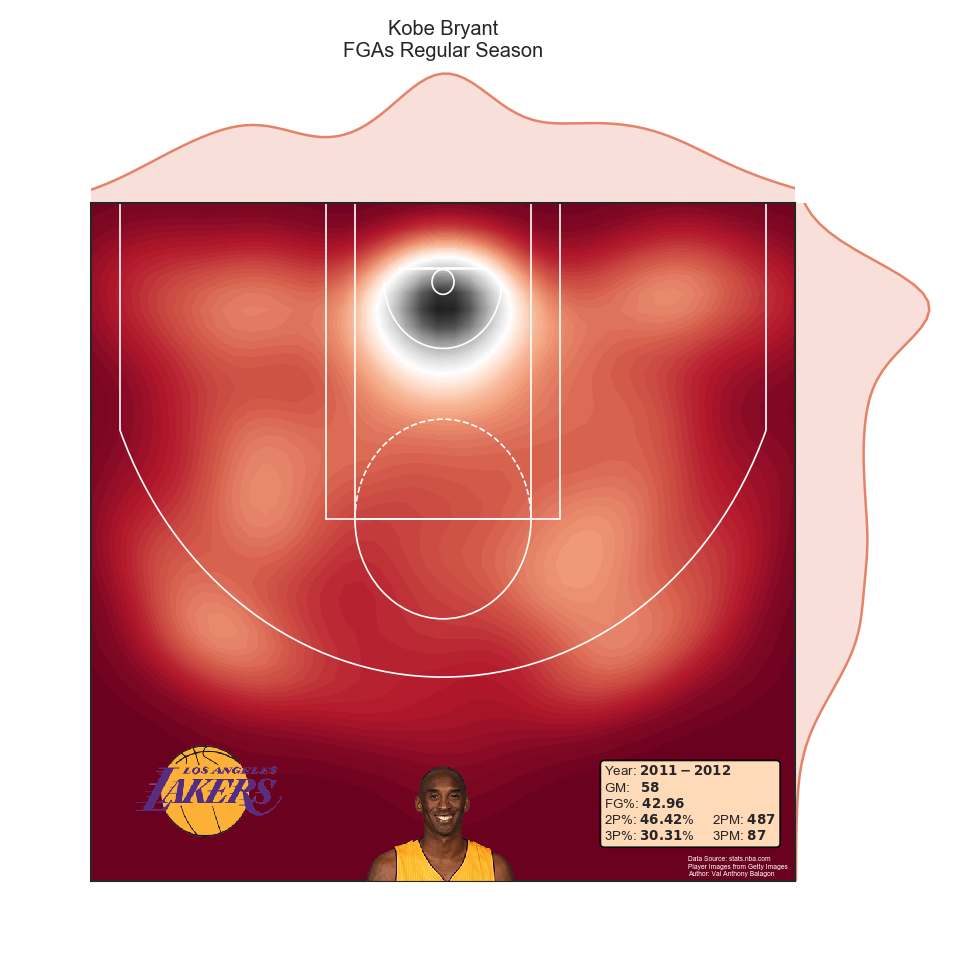

<IPython.core.display.Javascript object>


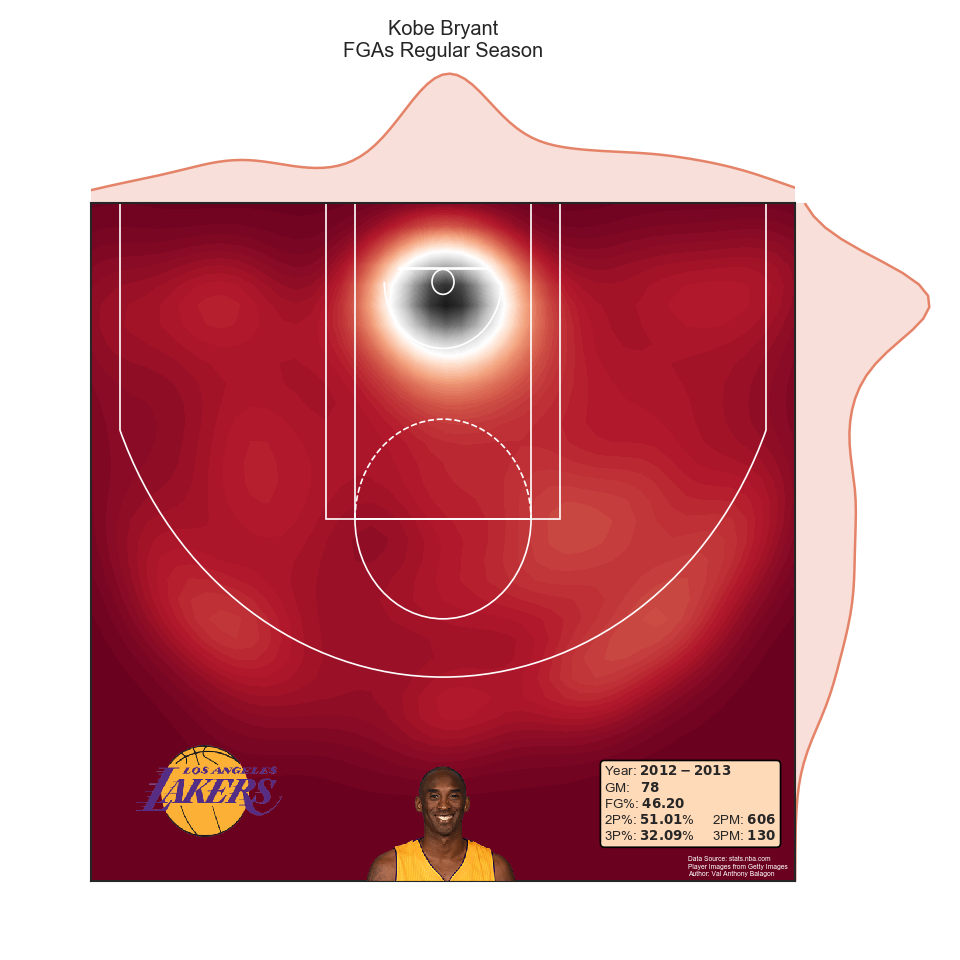

<IPython.core.display.Javascript object>


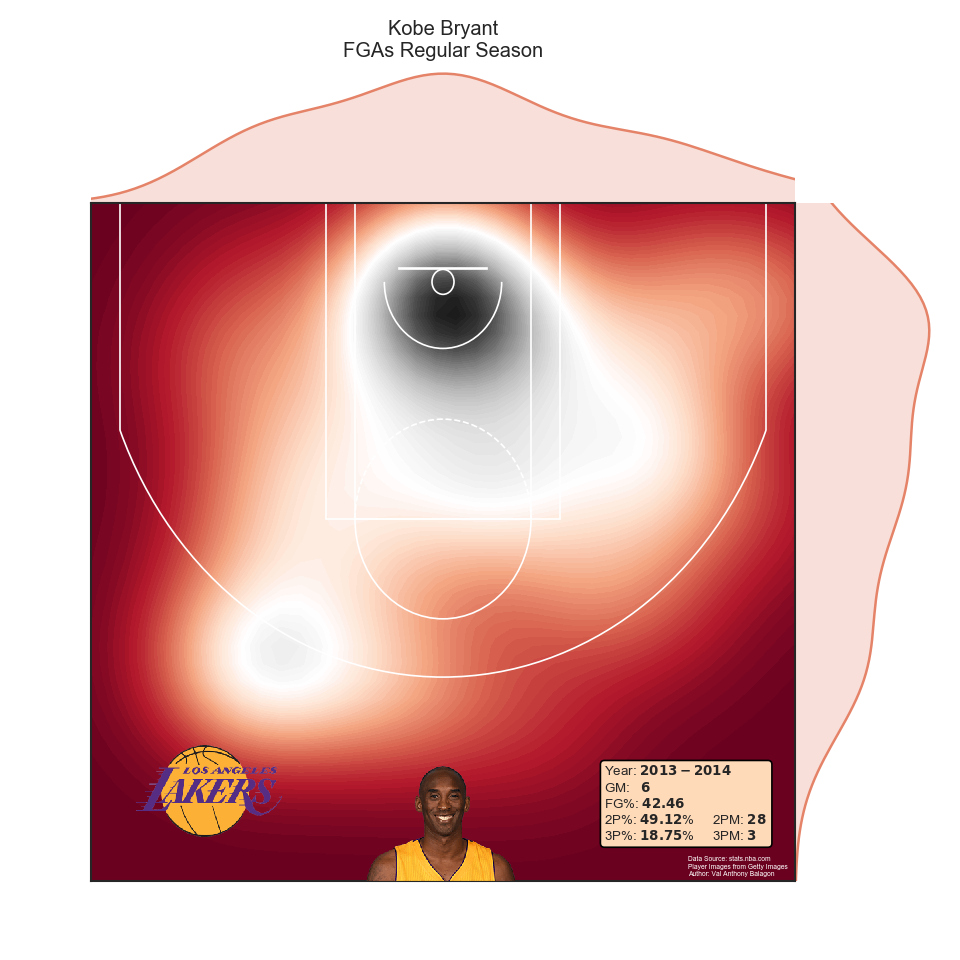

<IPython.core.display.Javascript object>


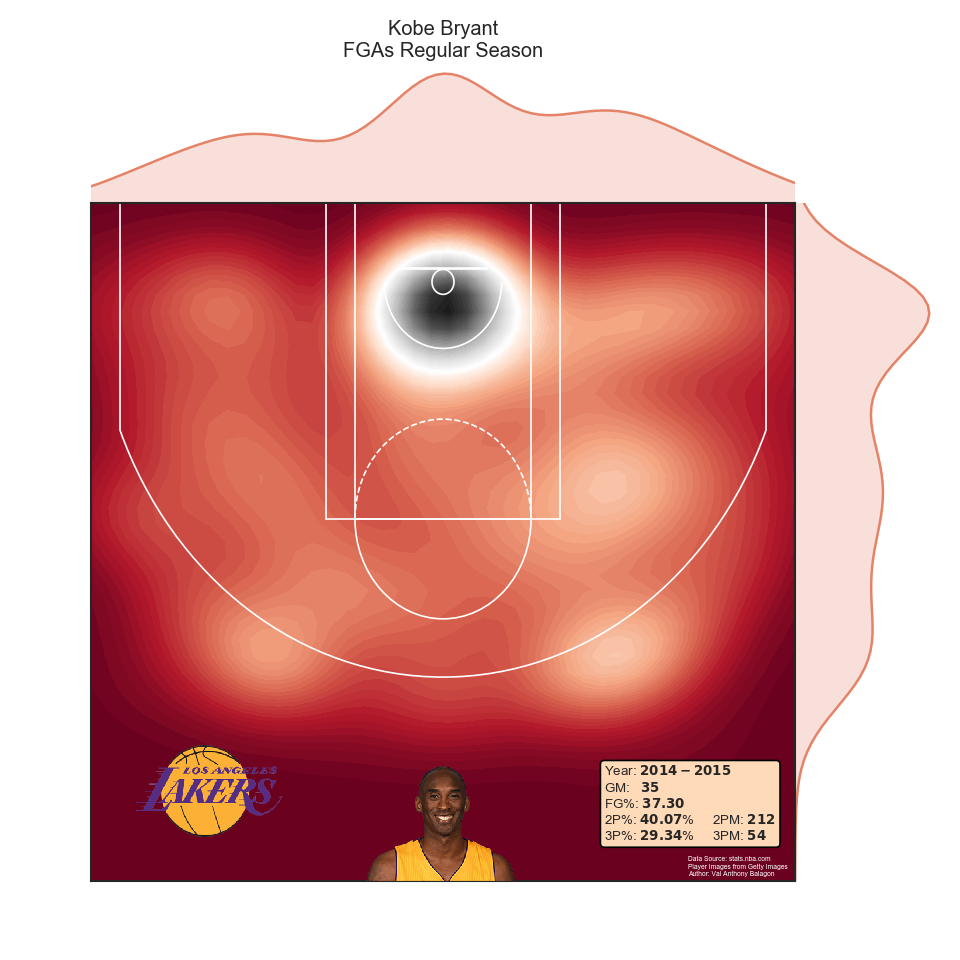

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


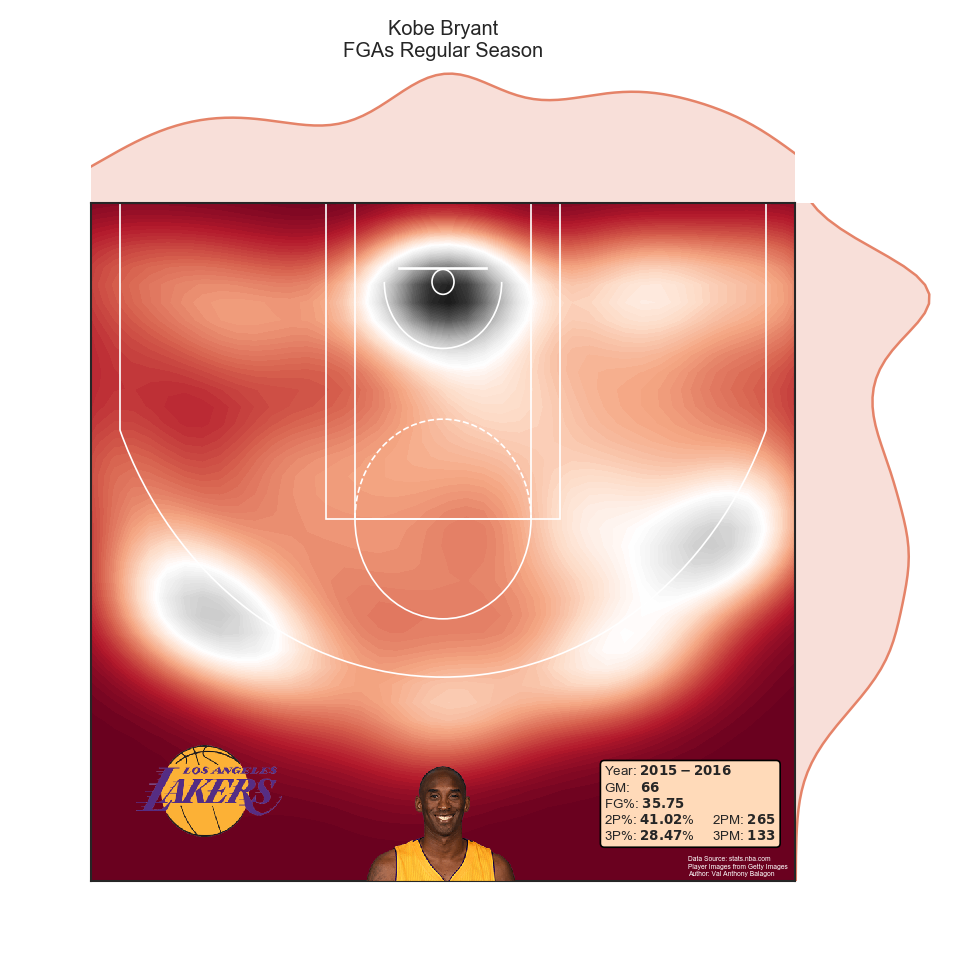

In [9]:
# Kobe!!!
make_gif(977, 1996, 2016, 0, 2, save=True, model_and_params=None)

# Bugs
1. Doesnt work: [203081, 2012,2019] (Damian Lillard), [101108, 2005, 2019] (CP3),[200755, 2006, 2019] (JJ Redick)
2. Centers usuall have tearing because they don't shoot 3s
3. Players 0% shooting do not print stats properly

# Error Catching
1. If data is unavailable, print (no data)

# Lakers Players

1. LBJ = 2544
2. Kyle Kuzma = 1628398
3. Brandon Ingram = 1627742
4. Lonzo Ball = 1628366
5. KCP = 203484
6. Josh Hart = 1628404
7. JaVale = 201580
8. Lance Stephenson = 202362
9. Tyson Chandler = 2199
10. Svi = 1629004
11. Rondo = 200765
12. Mo Wagner = 1629021
13. Beaseley = 201563
14. Zubac = 1627826
15. Caruso = 1627936
16. Isaac Bonga = 1629067

# Famous players

1. LBJ = 2544
2. KD = 201142
3. Giannis = 203507
4. Westbrook = 201566
5. Kyrie = 202681
6. Dame = 203081
7. AD = 203076
8. Harden = 201935
9. Kobe = 977
10. Derozan = 201942
11. LMA = 200746
12. Kahwi = 202695
13. DWade = 2548
14. Ben Simmons = 1627732
15. Joel Embiid = 203954
16. Devin Booker = 1626164
17. Kyle Kuzma = 1628398
18. Brandon Ingram = 1627742
19. Kemba = 202689
20. Paul George = 202331
21. Chris Paul = 101108
22. Beal = 203078
23. Jayson Tatum = 1628369
24. Porzingis = 204001
25. Andrew Wiggins = 203952
26. KAT = 1626157
27. Zach Lavine = 203897
28. Marc Gasol = 201188
29. Tobias Harris = 202699
30. Blake Griffin = 201933
31. Oladipo = 203506
32. Buddy Hield = 1627741
33. Vucevic = 202696
34. D'Angelo Russel = 1626156
35. Paul Pierce = 1718
36. MJ = 893
37. Karl Malone = 252
38. Melo = 2546
39. Dirk = 1717
40. KG = 708
41. Timmy D = 1495


# 3-PT Shooters
1. Ray Allen = 951
2. Steph = 201939
3. Klay = 202691
4. Korver = 2594
5. JJ Redick = 200755

# Rookies
1. Luka Doncic - 1629029
2. Trae Young - 1629027

# Sophomores
1. Lonzo Ball = 1628366
2. Donovan Mitchell = 1628378
3. Jayson Tatum = 1628369